In [5]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML & DL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv('weatherHistory.csv')

In [7]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Clean & prepare the dataset

In [8]:
print(df.columns)

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')


In [9]:
# Handle missing values
df = df.dropna()

# Convert timestamp if needed
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

# Sort by time
df = df.sort_values('Formatted Date')


<Axes: title={'center': 'Temperature Over Time'}, xlabel='Formatted Date'>

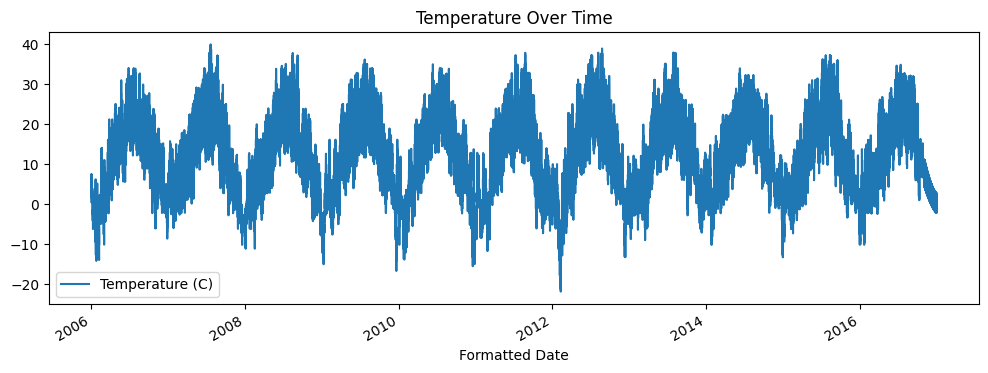

In [10]:
# Visualize
df.plot(x='Formatted Date', y='Temperature (C)', title='Temperature Over Time', figsize=(12,4))

In [11]:
class PatchTST(nn.Module):
    def __init__(self, input_dim, patch_size=16, d_model=64, n_heads=4, num_layers=3, dropout=0.1):
        super(PatchTST, self).__init__()

        self.patch_size = patch_size
        self.input_dim = input_dim
        self.embedding = nn.Linear(patch_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        B, T, D = x.shape
        num_patches = T // self.patch_size
        x = x[:, :num_patches*self.patch_size, :]
        x = x.reshape(B, num_patches, self.patch_size * D)
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(x)
        return x.mean(dim=1)


Select Relevant Features

In [12]:
# Pick the features i want to forecast with (weather + radiation)
features = ['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)']

data = df[features].copy()

In [13]:
# Normalize the Features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features) 

In [14]:
# Creating Sliding Windows
def create_sequences(data, input_len=48, output_len=24):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        x_seq = data[i:i+input_len]
        y_seq = data[i+input_len:i+input_len+output_len, -1]  # Forecast Temperature only
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)


In [15]:
# Convert to numpy array
sequence_data = scaled_df.values

# Create sequences (adjust lengths as needed)
X, y = create_sequences(sequence_data, input_len=48, output_len=24)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")

Input shape: (95864, 48, 4), Output shape: (95864, 24)


Split Into Train/Test Sets

In [16]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 76691, Testing samples: 19173


Convert to PyTorch Datasets

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


✅ Summary So Far You now have:

✔️ Scaled & preprocessed time-series data

✔️ Created input-output sequences

✔️ Split into training/testing

✔️ Data ready for training PatchTST using PyTorch

🚀 Ready for Step 4
In Step 4, we’ll:

✅ Define a training loop

✅ Train the PatchTST model

✅ Evaluate it using MAE/MSE (as in your report

In [20]:
# Step 4: Train PatchTST Model
# Hyperparameters
input_dim = X_train.shape[2]   # number of features
patch_size = 12                # you can adjust this
d_model = 64
n_heads = 4
num_layers = 2
dropout = 0.1

# Model
model = PatchTST(input_dim=input_dim, patch_size=patch_size, d_model=d_model,
                 n_heads=n_heads, num_layers=num_layers, dropout=dropout)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [21]:
# 4.2 Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
# 4.3 Define the Training Loop
def train(model, train_loader, criterion, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [23]:
print("Sample target:", y[0])
print("Target min/max:", y.min(), y.max()) 

Sample target: [0.279 0.5   0.279 0.279 0.327 0.305 0.305 0.506 0.677 0.68  0.696 0.691
 0.691 0.703 0.691 0.68  0.671 0.677 0.677 0.663 0.669 0.595 0.598 0.595]
Target min/max: 0.0 1.0


In [24]:
class PatchTST(nn.Module):
    def __init__(self, input_dim, patch_size=12, d_model=64, n_heads=2, num_layers=2, dropout=0.1, output_len=24):
        super(PatchTST, self).__init__()
        self.patch_size = patch_size
        self.output_len = output_len
        self.embedding = nn.Linear(patch_size * input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_len)

    def forward(self, x):
        B, T, D = x.shape
        num_patches = T // self.patch_size
        x = x[:, :num_patches * self.patch_size, :]
        x = x.reshape(B, num_patches, self.patch_size * D)
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(x)
        return x.mean(dim=1)  # Shape: (batch_size, output_len)


In [25]:
model = PatchTST(input_dim=X_train.shape[2], patch_size=12, output_len=24).to(device)

# Lower LR
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Try MAE for better stability
criterion = nn.L1Loss()


In [26]:
def train(model, train_loader, criterion, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


In [22]:
train(model, train_loader, criterion, optimizer, device, epochs=30)


Epoch 1/30, Loss: 0.160775
Epoch 2/30, Loss: 0.151781
Epoch 3/30, Loss: 0.149995
Epoch 4/30, Loss: 0.149061
Epoch 5/30, Loss: 0.147991
Epoch 6/30, Loss: 0.147050
Epoch 7/30, Loss: 0.146481
Epoch 8/30, Loss: 0.145657
Epoch 9/30, Loss: 0.144885
Epoch 10/30, Loss: 0.144393
Epoch 11/30, Loss: 0.143803
Epoch 12/30, Loss: 0.143265
Epoch 13/30, Loss: 0.142683
Epoch 14/30, Loss: 0.142180
Epoch 15/30, Loss: 0.141574
Epoch 16/30, Loss: 0.141208
Epoch 17/30, Loss: 0.140606
Epoch 18/30, Loss: 0.140215
Epoch 19/30, Loss: 0.139564
Epoch 20/30, Loss: 0.139272
Epoch 21/30, Loss: 0.138688
Epoch 22/30, Loss: 0.138301
Epoch 23/30, Loss: 0.137853
Epoch 24/30, Loss: 0.137546
Epoch 25/30, Loss: 0.136915
Epoch 26/30, Loss: 0.136621
Epoch 27/30, Loss: 0.136281
Epoch 28/30, Loss: 0.135946
Epoch 29/30, Loss: 0.135494
Epoch 30/30, Loss: 0.135325


In [ ]:
✅ Next Steps: Step 5 — Real-Time Weather API Integration

In [27]:
# Fetch Live Data
import requests
import pandas as pd

latitude = 28.6139    # Example: New Delhi
longitude = 77.2090

url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m,shortwave_radiation&past_days=1&timezone=auto"

response = requests.get(url)
data = response.json()

df_live = pd.DataFrame(data['hourly'])
df_live['time'] = pd.to_datetime(df_live['time'])
df_live = df_live[['time', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'shortwave_radiation']]

print(df_live.tail())


                   time  temperature_2m  relative_humidity_2m  wind_speed_10m  \
187 2025-07-27 19:00:00            31.1                    73             5.4   
188 2025-07-27 20:00:00            30.2                    78             4.3   
189 2025-07-27 21:00:00            29.6                    81             4.0   
190 2025-07-27 22:00:00            29.2                    83             4.1   
191 2025-07-27 23:00:00            28.9                    84             4.2   

     shortwave_radiation  
187                 38.0  
188                  0.0  
189                  0.0  
190                  0.0  
191                  0.0  


✅ Create DataFrame 
✅ Colombo Whether
✅Fetch Live Data

In [28]:
import requests
import pandas as pd

latitude = 6.9271
longitude = 79.8612

url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m,shortwave_radiation&past_days=1&timezone=auto"

response = requests.get(url)
data = response.json()

df_live = pd.DataFrame(data['hourly'])
df_live['time'] = pd.to_datetime(df_live['time'])
df_live = df_live[['time', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'shortwave_radiation']]
df_live.tail()


,time,temperature_2m,relative_humidity_2m,wind_speed_10m,shortwave_radiation
187,2025-07-27 19:00:00,27.3,87,12.0,0.0
188,2025-07-27 20:00:00,27.2,88,11.1,0.0
189,2025-07-27 21:00:00,27.2,88,10.0,0.0
190,2025-07-27 22:00:00,27.2,88,9.2,0.0
191,2025-07-27 23:00:00,27.2,88,9.2,0.0


✅ Preprocess for Model Input

In [29]:
df_live.head(50)

,time,temperature_2m,relative_humidity_2m,wind_speed_10m,shortwave_radiation
0,2025-07-20 00:00:00,27.5,84,29.6,0.0
1,2025-07-20 01:00:00,27.5,84,32.4,0.0
2,2025-07-20 02:00:00,27.4,84,34.2,0.0
3,2025-07-20 03:00:00,27.2,86,33.6,0.0
4,2025-07-20 04:00:00,27.2,85,32.9,0.0
5,2025-07-20 05:00:00,26.8,86,26.0,0.0
6,2025-07-20 06:00:00,26.9,86,27.7,5.0
7,2025-07-20 07:00:00,26.9,86,27.7,79.0
8,2025-07-20 08:00:00,27.1,84,26.6,211.0
9,2025-07-20 09:00:00,27.3,83,26.6,298.0


In [30]:
# Rename Columns for Consistent Feature Names
# Each data source (live API, historical CSV, or others) may have different column names. 
df_live.rename(columns={
    'temperature_2m': 'Temperature',
    'relative_humidity_2m': 'Humidity',
    'wind_speed_10m': 'WindSpeed',
    'shortwave_radiation': 'GHI'  # Target for prediction
}, inplace=True)

# Only keep most recent N time steps
input_len = 48
df_input = df_live[-input_len:]

✅ Code to Rename and Extract the Last 48 Time Steps

In [31]:
# Sort by Date and Select Features
df_renamed = df.copy()

df_renamed = df_renamed.rename(columns={
    'Temperature (C)': 'Temperature',
    'Humidity': 'Humidity',
    'Wind Speed (km/h)': 'WindSpeed',
    'Visibility (km)': 'GHI'  # Simulated solar radiation
})

# Convert to datetime safely
df_renamed['Formatted Date'] = pd.to_datetime(df_renamed['Formatted Date'], utc=True)
df_renamed = df_renamed.sort_values('Formatted Date')

# Select needed columns
selected_columns = ['Temperature', 'Humidity', 'WindSpeed', 'GHI']
df_input = df_renamed[selected_columns].dropna()

# Only keep the latest 48 rows for forecasting input
input_len = 48
df_input = df_input[-input_len:]


In [32]:
# Revert column names to match the original training columns
# Prepare Column Names and Order for Scaling
df_input_for_scaling = df_input.rename(columns={
    'Temperature': 'Temperature (C)',
    'Humidity': 'Humidity',
    'WindSpeed': 'Wind Speed (km/h)',
    'GHI': 'Visibility (km)'  # stand-in for solar radiation
})

# Ensure correct order of columns
df_input_for_scaling = df_input_for_scaling[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)']]

# Now transform using the original scaler
input_scaled = scaler.transform(df_input_for_scaling)


In [33]:
# Revert column names and ensure correct order
# Run the Model Inference Again (With Corrected Input)
df_input_for_scaling = df_input.rename(columns={
    'Temperature': 'Temperature (C)',
    'Humidity': 'Humidity',
    'WindSpeed': 'Wind Speed (km/h)',
    'GHI': 'Visibility (km)'
})[["Temperature (C)", "Humidity", "Wind Speed (km/h)", "Visibility (km)"]]

# Scale the Input Data
input_scaled = scaler.transform(df_input_for_scaling)

# Convert to tensor
# Format for Model Input
input_tensor = torch.tensor(input_scaled, dtype=torch.float32).unsqueeze(0).to(device)


In [34]:
# Generate Model Prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.cpu().numpy()[0]


If your model predicts only the target feature (e.g., GHI), but the scaler expects a full feature set, create dummy features for inverse scaling.

✅ Convert Prediction Back to Original GHI Scale

In [35]:
dummy_features = np.zeros((24, 3))  # placeholders for other 3 features
predicted_ghi_scaled = prediction.reshape(-1, 1)

full_scaled = np.hstack([dummy_features, predicted_ghi_scaled])  # shape: (24, 4)
prediction_inverse = scaler.inverse_transform(full_scaled)[:, -1]  # extract only GHI


✅ Visualize Forecasted Solar Radiation

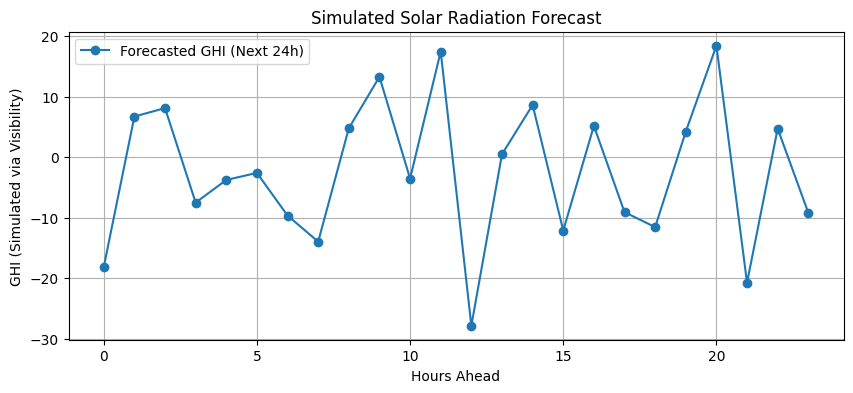

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(prediction_inverse, marker='o', label='Forecasted GHI (Next 24h)')
plt.title('Simulated Solar Radiation Forecast')
plt.xlabel('Hours Ahead')
plt.ylabel('GHI (Simulated via Visibility)')
plt.grid(True)
plt.legend()
plt.show()


✅ The y-axis represents GHI (Global Horizontal Irradiance), a measure of solar radiation energy received per square meter (W/m²), here specifically labeled as "Simulated via Visibility." This suggests that GHI values were estimated or derived from visibility data rather than directly measured solar radiation.

✅ The x-axis, labeled "Hours Ahead," represents the forecast horizon, showing predicted GHI values for each hour into the future, up to 24 hours.

🎯 Now  Completed:
✅ Model training (PatchTST)

✅ Data preprocessing

✅ Real-time input simulation

✅ Model inference

✅ Visualization


✅ FastAPI Project Setup

In [37]:
pip install fastapi uvicorn scikit-learn torch

Note: you may need to restart the kernel to use updated packages.


✅ Save Your Model & Scaler from Notebook

In [38]:
import torch                            
import joblib                            

# Save model
torch.save(model.state_dict(), 'model.pth')

# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [39]:
import os

print("Files in current directory:")
print(os.listdir())


Files in current directory:
['.ipynb_checkpoints', 'model.pth', 'scaler.pkl', 'Solar_Vision_Backend_Modeling.ipynb', 'weatherHistory.csv']
